In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras

In [46]:
train= pd.read_csv('/content/Price_Train.csv')
test= pd.read_csv('/content/Price_Test.csv')

In [47]:
train.head()

,Date,Open,High,Low,Close,Volume
0,03-01-2005,16.268,16.322,15.863,16.119,3580384
1,04-01-2005,16.052,16.194,15.560,15.694,3970435
2,05-01-2005,15.640,15.964,15.608,15.687,4131760
3,06-01-2005,15.797,15.824,15.316,15.344,3347065
4,07-01-2005,15.309,15.492,15.275,15.330,2780878


In [48]:
#taking open price from data in 2d array , if we will do train.loc[:, 'open'].values it gives one d array which wont
#be considered in scaling
train_open= train.iloc[:, 1:2].values


In [49]:
#Scaling the values between 0 to 1
from sklearn.preprocessing import MinMaxScaler
ss= MinMaxScaler(feature_range=(0,1))
train_open_scaled= ss.fit_transform(train_open)

In [50]:
train_open_scaled[60]

array([0.16719862])

In [51]:
# Feature selection
xtrain=[]
ytrain=[]
for i in range(60,len(train_open_scaled)):
    xtrain.append(train_open_scaled[i-60:i,0])
    ytrain.append(train_open_scaled[i,0])

xtrain, ytrain = np.array(xtrain), np.array(ytrain)

In [52]:
#Reshaping the train data to make it as input for LTSM layer input_shape(batchzise,timesteps,input_dim)
xtrain= np.reshape(xtrain,(xtrain.shape[0],xtrain.shape[1],1))

In [53]:
xtrain.shape

(2939, 60, 1)

### Building the LSTM Network

In [31]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

In [32]:
#initialisizng the model 
regression= Sequential()

#First Input layer and LSTM layer with 0.2% dropout
regression.add(LSTM(units=50,return_sequences=True,kernel_initializer='glorot_uniform',input_shape=(xtrain.shape[1],1)))
regression.add(Dropout(0.2))

# Where:
#     return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.

# Second LSTM layer with 0.2% dropout
regression.add(LSTM(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
regression.add(Dropout(0.2))

#Third LSTM layer with 0.2% dropout
regression.add(LSTM(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
regression.add(Dropout(0.2))

#Fourth LSTM layer with 0.2% dropout, we wont use return sequence true in last layers as we dont want to previous output
regression.add(LSTM(units=50,kernel_initializer='glorot_uniform'))
regression.add(Dropout(0.2))
#Output layer , we wont pass any activation as its continous value model
regression.add(Dense(units=1))

#Compiling the network
regression.compile(optimizer='adam',loss='mean_squared_error')


#fitting the network
regression.fit(xtrain,ytrain,batch_size=30,epochs=100)

Epoch 1/100
98/98 [==============================] - 20s 136ms/step - loss: 0.0179
Epoch 2/100
98/98 [==============================] - 14s 142ms/step - loss: 0.0044
Epoch 3/100
98/98 [==============================] - 12s 127ms/step - loss: 0.0042
Epoch 4/100
98/98 [==============================] - 13s 136ms/step - loss: 0.0036
Epoch 5/100
98/98 [==============================] - 13s 133ms/step - loss: 0.0033
Epoch 6/100
98/98 [==============================] - 13s 131ms/step - loss: 0.0029
Epoch 7/100
98/98 [==============================] - 13s 128ms/step - loss: 0.0031
Epoch 8/100
98/98 [==============================] - 13s 133ms/step - loss: 0.0028
Epoch 9/100
98/98 [==============================] - 12s 126ms/step - loss: 0.0028
Epoch 10/100
98/98 [==============================] - 13s 132ms/step - loss: 0.0029
Epoch 11/100
98/98 [==============================] - 13s 135ms/step - loss: 0.0024
Epoch 12/100
98/98 [==============================] - 14s 142ms/step - loss: 0.0023
E

### Predicting for test data

As we have 60 input in our layer, we will concatenate our train and test and will take last 60 values of our training set with test set

In [54]:

test_open= test.iloc[:, 1:2].values #taking  open price
total= pd.concat([train['Open'],test['Open']],axis=0) # Concating train and test and then will take last 60 train point
test_input = total[len(total)-len(test)-60:].values
test_input= test_input.reshape(-1,1) # reshaping it to get it transformed
test_input= ss.transform(test_input)

In [55]:
xtest= []
for i in range(60,80):
    xtest.append(test_input[i-60:i,0]) #creating input for lstm prediction

In [56]:
xtest= np.array(xtest)

In [57]:
xtest= np.reshape(xtest,(xtest.shape[0],xtest.shape[1],1))
predicted_value= regression.predict(xtest)

In [58]:
predicted_value= ss.inverse_transform(predicted_value)

In [59]:
predicted_value

array([[44.788456],
       [44.8818  ],
       [45.133755],
       [45.19255 ],
       [45.420982],
       [45.999363],
       [46.36906 ],
       [46.56873 ],
       [46.72223 ],
       [46.62478 ],
       [46.874336],
       [46.63184 ],
       [46.451965],
       [46.64482 ],
       [46.584805],
       [46.618416],
       [46.788593],
       [46.92643 ],
       [46.613914],
       [46.52701 ]], dtype=float32)

In [60]:
test_open

array([[43.786],
       [44.152],
       [44.133],
       [44.56 ],
       [45.471],
       [45.738],
       [45.867],
       [45.985],
       [45.638],
       [46.163],
       [45.452],
       [45.312],
       [45.768],
       [45.49 ],
       [45.638],
       [45.927],
       [46.065],
       [45.374],
       [45.454],
       [45.621],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan],
       [   nan

### Plotting the data

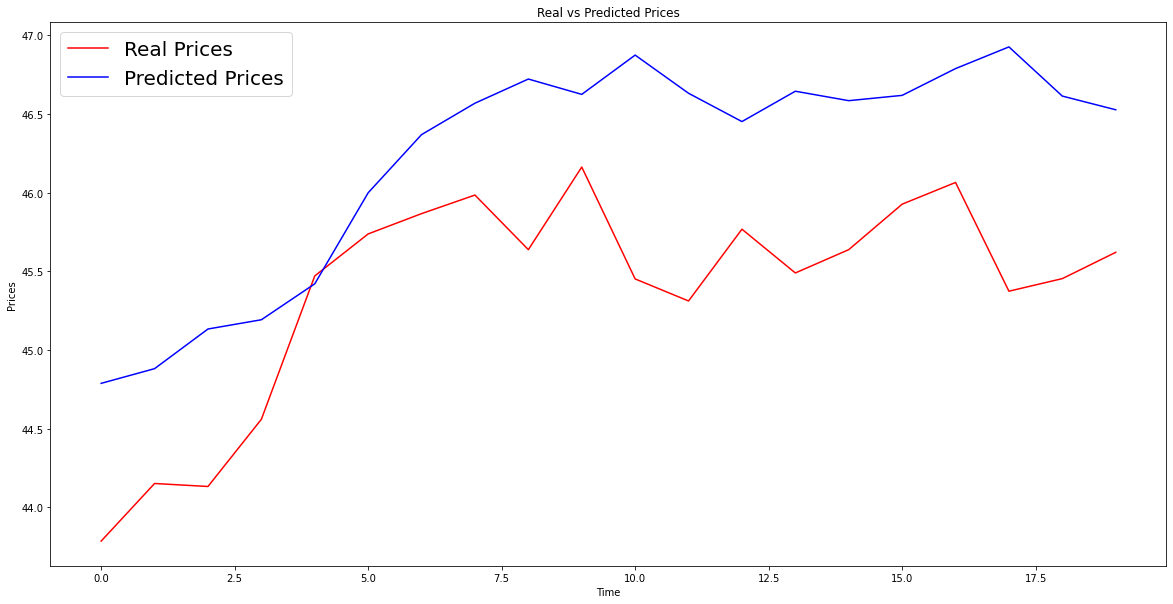

In [65]:
plt.figure(figsize=(20,10))
plt.plot(test_open,'red',label='Real Prices')
plt.plot(predicted_value,'blue',label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Real vs Predicted Prices')
plt.legend(loc='best', fontsize=20)


In [70]:
testt=test_open[0:20]
difference_array=np.subtract(predicted_value,testt)
squared_array = np. square(difference_array)
mse = squared_array. mean()
print(mse)

0.8516192517395387
